# CNN

In [ ]:
from google.colab import drive

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers

from tensorflow.keras.callbacks import EarlyStopping

keras.utils.set_random_seed(42)

## LOAD DATA

In [ ]:
# Load the Drive helper and mount

# This will prompt for authorization.
drive.mount('/content/drive')

project_folder = '/content/drive/My Drive/AML-Project-Frigerio-Napoli-Tremolada'

df_train = pd.read_csv(f'{project_folder}/train.csv')

Mounted at /content/drive


In [ ]:
test_data = pd.read_csv(f'{project_folder}/test.csv')
test_labels = pd.read_csv(f'{project_folder}/test_labels.csv')
df_test = pd.merge(test_data, test_labels, on='id')

In [ ]:
labels = ["toxic", "severe_toxic", "obscene", "threat", "insult","identity_hate"]

In [ ]:
df_test = df_test[(df_test[labels] >= 0).all(1)]
df_test.reset_index(inplace=True)
df_test = df_test.drop(columns=['index'])

In [ ]:
from sklearn.model_selection import train_test_split

X = df_train["comment_text"]
y = df_train[labels].values

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

X_test = df_test["comment_text"]
y_test = df_test[labels].values

In [ ]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

def preprocess(text):
  text = text.lower() # convert text to lowercase
  text = re.sub(r'\d+', '', text) # remove numbers
  text = str(text).replace("\n", " ") # remove newline characters
  text = re.sub(r'[^\w\s]', '', text) #
  text = text.replace("_", " ")
  text = re.sub("([^\x00-\x7F])+"," ",text) # Removing any non-ASCII characters
  text = text.strip() # remove whitespaces

  # remove stop words
  stop_words = set(stopwords.words('english'))
  word_tokens = word_tokenize(text)
  filtered_tokens = [token.lower() for token in word_tokens if token.lower() not in stop_words]

  # Lemmatize the tokens
  lemmatizer=WordNetLemmatizer()
  lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]

  # Join the tokens back into a string
  preprocessed_text = " ".join(lemmatized_tokens)

  return preprocessed_text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
X_train_pp = X_train.apply(preprocess)
X_val_pp = X_val.apply(preprocess)
X_test_pp = X_test.apply(preprocess)

In [ ]:
MAX_LEN = 200
VOCABULARY_SIZE = 200000

auto = tf.data.AUTOTUNE
text_vectorizer = layers.TextVectorization(
    max_tokens=VOCABULARY_SIZE, ngrams=1, output_mode="int",
    output_sequence_length=MAX_LEN
)

# `TextVectorization` layer needs to be adapted as per the vocabulary from our
# training set.
with tf.device("/CPU:0"):
    text_vectorizer.adapt(X_train_pp)

In [ ]:
X_train_vc = text_vectorizer(X_train_pp)
X_val_vc = text_vectorizer(X_val_pp)
X_test_vc = text_vectorizer(X_test_pp)

In [ ]:
ds_train = tf.data.Dataset.from_tensor_slices((X_train_vc, y_train))
ds_val = tf.data.Dataset.from_tensor_slices((X_val_vc, y_val))
ds_test = tf.data.Dataset.from_tensor_slices((X_test_vc, y_test))

In [ ]:
BATCH_SIZE = 64

ds_train = ds_train.cache().batch(BATCH_SIZE).prefetch(16)
ds_val = ds_val.cache().batch(BATCH_SIZE).prefetch(16)
ds_test = ds_test.cache().batch(BATCH_SIZE).prefetch(16)

## EMBEDDING

In [ ]:
EMBEDDING_DIM = 300
path_to_glove_file = f'/content/drive/My Drive/AML-toxic/glove/glove.6B.{EMBEDDING_DIM}d.txt'

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

vocabulary = text_vectorizer.get_vocabulary()
word_index = dict(zip(vocabulary, range(len(vocabulary))))

NUM_TOKEN = len(vocabulary) + 2

# Prepare embedding matrix
embedding_matrix = np.zeros((NUM_TOKEN, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector

In [ ]:
embedding_layer_glove = layers.Embedding(
    NUM_TOKEN,
    EMBEDDING_DIM,
    trainable=False,
)
embedding_layer_glove.build((1,))
embedding_layer_glove.set_weights([embedding_matrix])

In [ ]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

embedding_layer_pos = TokenAndPositionEmbedding(MAX_LEN, VOCABULARY_SIZE, EMBEDDING_DIM)

## MODELS

In [ ]:
FILTERS = 250 #number of filters
KERNEL_SIZE = 5 # a window size of 3 tokens

def make_model(emb_layer):
    inputs = keras.Input(shape=(MAX_LEN,))
    embedding = emb_layer(inputs)
    # x = keras.layers.Conv1D(FILTERS, KERNEL_SIZE, activation = 'relu')(embedding)
    # x = keras.layers.GlobalMaxPooling1D()(x)
    x = keras.layers.Conv1D(FILTERS*2, KERNEL_SIZE, activation = 'relu')(embedding)
    x = keras.layers.GlobalMaxPooling1D()(x)
    x = keras.layers.Dense(500, activation = 'relu')(x)
    x = keras.layers.Dropout(0.2)(x)
    outputs = layers.Dense(len(labels), activation = 'sigmoid')(x)

    return keras.Model(inputs, outputs)

In [ ]:
auc_metric = keras.metrics.AUC(multi_label=True)

In [ ]:
model_positional = make_model(embedding_layer_pos)
model_positional.summary()
model_positional.compile(
    loss="binary_crossentropy", optimizer="adam", metrics=["binary_accuracy", auc_metric]
)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200)]             0         
                                                                 
 token_and_position_embeddi  (None, 200, 300)          60060000  
 ng (TokenAndPositionEmbedd                                      
 ing)                                                            
                                                                 
 conv1d_1 (Conv1D)           (None, 196, 500)          750500    
                                                                 
 global_max_pooling1d_1 (Gl  (None, 500)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense (Dense)               (None, 500)               250500    
                                                             

In [ ]:
model_glove = make_model(embedding_layer_glove)
model_glove.summary()
model_glove.compile(
    loss="binary_crossentropy", optimizer=keras.optimizers.Adam(), metrics=["binary_accuracy", auc_metric]
)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 200)]             0         
                                                                 
 embedding (Embedding)       (None, 200, 300)          55011900  
                                                                 
 conv1d_3 (Conv1D)           (None, 196, 500)          750500    
                                                                 
 global_max_pooling1d_3 (Gl  (None, 500)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_2 (Dense)             (None, 500)               250500    
                                                                 
 dropout_1 (Dropout)         (None, 500)               0         
                                                           

## TRAIN AND EVALUATE

### UTILITY FUNCTIONS

In [ ]:
import matplotlib.pyplot as plt

def plot_result(history, item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()

In [ ]:
def train_model(m, es):
  history = m.fit(ds_train, validation_data=ds_val, epochs=20, callbacks=[es])
  plot_result(history, "loss")
  plot_result(history, "binary_accuracy")
  plot_result(history, "auc")

In [ ]:
from sklearn.metrics import roc_auc_score, classification_report

def print_roc(y_true, y_preds):
  print("ROC AUC Score per Label\t",roc_auc_score(y_true,y_preds,average=None))
  print("Micro ROC AUC Score\t",roc_auc_score(y_true,y_preds,average="micro"))
  print("Macro ROC AUC Score\t",roc_auc_score(y_true,y_preds,average="macro"))
  print("Weighted ROC AUC Score\t",roc_auc_score(y_true,y_preds,average="weighted"))
  print(classification_report(y_true, (y_preds > 0.5), target_names=labels))

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay

def print_cms(y_true, y_preds):
  cms = multilabel_confusion_matrix(y_true, (y_preds > 0.5))

  for cm, l in zip(cms, labels):
    true_neg, false_pos, false_neg, true_pos = cm.ravel()
    acc = (true_pos + true_neg) / (true_pos + true_neg + false_pos + false_neg)
    recall = true_pos / (true_pos + false_neg)
    precision = true_pos / (true_pos + false_pos)
    f1_score = 2 * ((precision * recall) / (precision + recall))
    print(f'{l} - Acc: {acc:.4f} - Recall: {recall:.4f} - Precision: {precision:.4f} - F1 score: {f1_score:.4f}')
    ConfusionMatrixDisplay(cm).plot()
    plt.show()

In [ ]:
def model_metrics(m):
  y_preds = m.predict(ds_test.map(lambda text, label: text))
  y_true = np.concatenate([y for x, y in ds_test], axis=0)
  print_roc(y_true, y_preds)
  print_cms(y_true, y_preds)
  return y_preds

In [ ]:
from operator import itemgetter

vocab_arr = np.asarray(vocabulary)
def seq_to_text(seq):
  return " ".join(vocab_arr[seq])

def model_comments(pos, model_preds):
  toxic_indices = [i for i, x in enumerate(np.array(y_train)) if x[pos]==1]
  toxic_comments = np.array(X_train_pp)[np.array(toxic_indices)]
  toxic_labels = np.array(y_train)[np.array(toxic_indices)]
  y_preds_converted = (model_preds > 0.5).astype(int)
  count = 0
  for t, l, pred in zip(toxic_comments, toxic_labels, y_preds_converted):
    if not np.any(pred):
      count += 1
    print(f'-----\n{t}:\n\t{l}\t{pred}')
  return ((count *100)/ len(model_preds))

### POSITIONAL

Epoch 1/20
1995/1995 [==============================] - 171s 82ms/step - loss: 0.0617 - binary_accuracy: 0.9789 - auc: 0.9394 - val_loss: 0.0494 - val_binary_accuracy: 0.9817 - val_auc: 0.9619
Epoch 2/20
1995/1995 [==============================] - 64s 32ms/step - loss: 0.0355 - binary_accuracy: 0.9859 - auc: 0.9826 - val_loss: 0.0542 - val_binary_accuracy: 0.9810 - val_auc: 0.9486
Epoch 3/20
1995/1995 [==============================] - 63s 32ms/step - loss: 0.0261 - binary_accuracy: 0.9895 - auc: 0.9901 - val_loss: 0.0630 - val_binary_accuracy: 0.9776 - val_auc: 0.9337


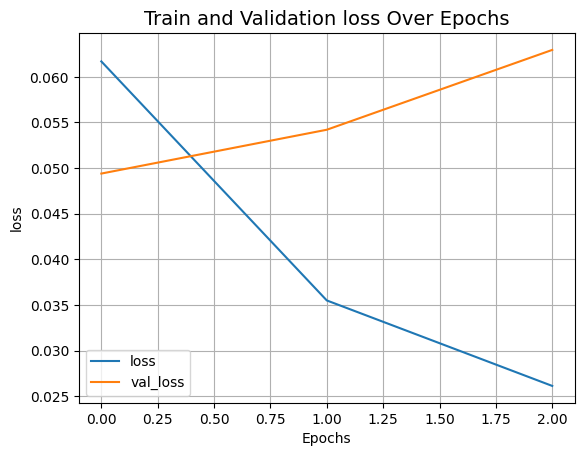

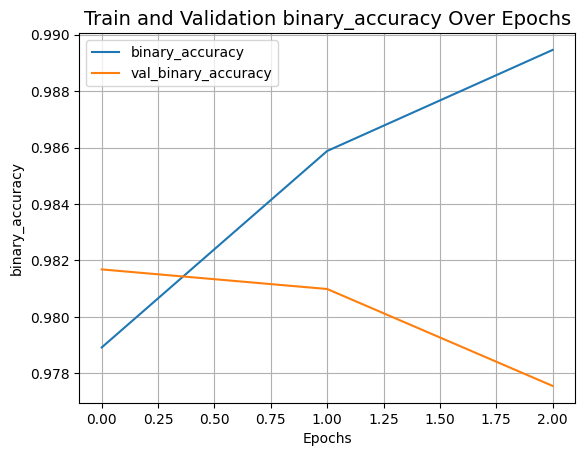

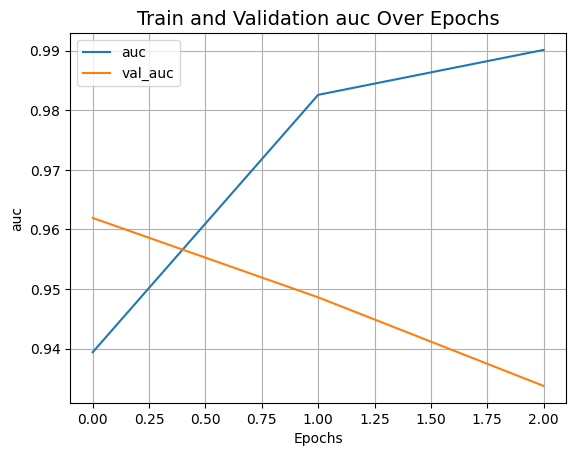

In [ ]:
train_model(model_positional, EarlyStopping(monitor="val_loss", min_delta = 0.01, patience=2, restore_best_weights=True))

In [ ]:
model_positional.evaluate(ds_test)

1000/1000 [==============================] - 7s 7ms/step - loss: 0.0757 - binary_accuracy: 0.9692 - auc: 0.9620


[0.07565320283174515, 0.9691529870033264, 0.9619724154472351]

1000/1000 [==============================] - 5s 5ms/step
ROC AUC Score per Label	 [0.96182434 0.9862536  0.97379403 0.96843826 0.96862368 0.96323212]
Micro ROC AUC Score	 0.9761089024257666
Macro ROC AUC Score	 0.9703610055555046
Weighted ROC AUC Score	 0.9672626673813299


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


               precision    recall  f1-score   support

        toxic       0.53      0.86      0.66      6090
 severe_toxic       0.38      0.04      0.07       367
      obscene       0.67      0.68      0.67      3691
       threat       0.00      0.00      0.00       211
       insult       0.60      0.67      0.64      3427
identity_hate       0.75      0.00      0.01       712

    micro avg       0.58      0.69      0.63     14498
    macro avg       0.49      0.38      0.34     14498
 weighted avg       0.58      0.69      0.60     14498
  samples avg       0.08      0.07      0.07     14498

toxic - Acc: 0.9145 - Recall: 0.8585 - Precision: 0.5316 - F1 score: 0.6566


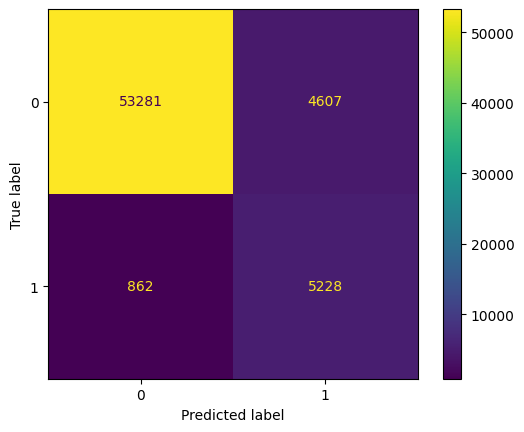

severe_toxic - Acc: 0.9941 - Recall: 0.0409 - Precision: 0.3846 - F1 score: 0.0739


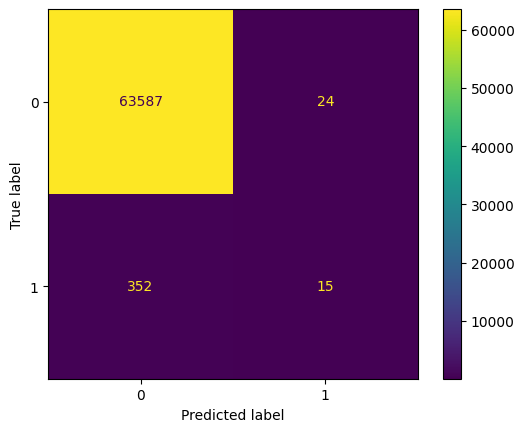

obscene - Acc: 0.9621 - Recall: 0.6771 - Precision: 0.6700 - F1 score: 0.6735


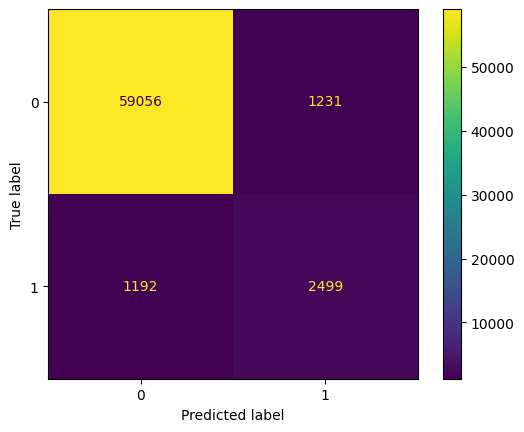

<ipython-input-23-e33fee1fdeaa>:10: RuntimeWarning: invalid value encountered in long_scalars
  precision = true_pos / (true_pos + false_pos)


threat - Acc: 0.9967 - Recall: 0.0000 - Precision: nan - F1 score: nan


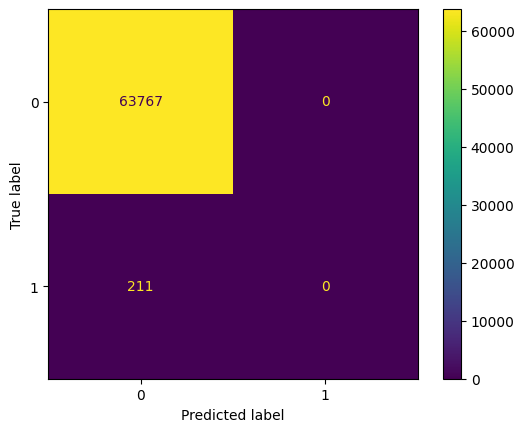

insult - Acc: 0.9585 - Recall: 0.6732 - Precision: 0.6009 - F1 score: 0.6350


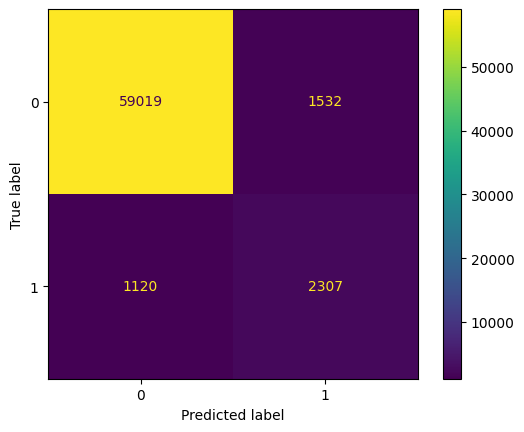

identity_hate - Acc: 0.9889 - Recall: 0.0042 - Precision: 0.7500 - F1 score: 0.0084


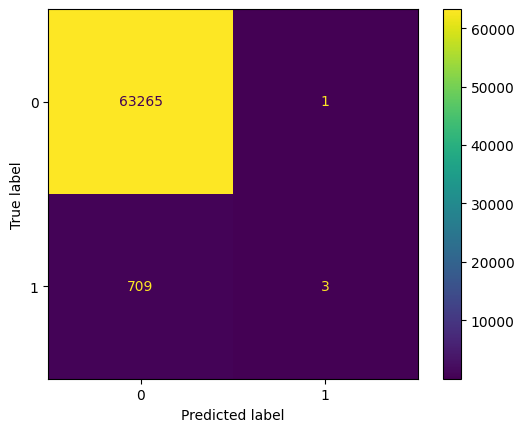

In [ ]:
mp_preds = model_metrics(model_positional)

In [ ]:
all_zero_predictions = model_comments(3, mp_preds)
print(f'Percentage of all-zero predictions {all_zero_predictions:.4f} %')

-----
fucking cunt head tell welcome go fucking die twice cunt deserve gassing:
	[1 0 1 1 1 0]	[0 0 0 0 0 0]
-----
shut asswipe dont care ill decapitate mother shit herhis neck go back jewland fuck httpenwikipediaorgwikithe real stephen hawkinghttpenwikipediaorgwikithe real stephen hawkinghttpenwikipediaorgwikithe real stephen hawkinghttpenwikipediaorgwikithe real stephen hawkinghttpenwikipediaorgwikithe real stephen hawkinghttpenwikipediaorgwikithe real stephen hawkinghttpenwikipediaorgwikithe real stephen hawkinghttpenwikipediaorgwikithe real stephen hawkinghttpenwikipediaorgwikithe real stephen hawkinghttpenwikipediaorgwikithe real stephen hawkinghttpenwikipediaorgwikithe real stephen hawkinghttpenwikipediaorgwikithe real stephen hawkinghttpenwikipediaorgwikithe real stephen hawkinghttpenwikipediaorgwikithe real stephen hawkinghttpenwikipediaorgwikithe real stephen hawkinghttpenwikipediaorgwikithe real stephen hawkinghttpenwikipediaorgwikithe real stephen hawkinghttpenwikipediaorgwi

In [ ]:
all_zero_predictions = model_comments(5, mp_preds)
print(f'Percentage of all-zero predictions {all_zero_predictions:.4f} %')

-----
usernawlinwiki gay person gay deleted spunka page gayyyyyyyyyyy:
	[1 0 0 0 1 1]	[0 0 0 0 0 0]
-----
ea bunch homosexual like make good game ruin making money game fp ea bunch homosexual like make good game ruin making money game fp ea bunch homosexual like make good game ruin making money game fp ea bunch homosexual like make good game ruin making money game fp ea bunch homosexual like make good game ruin making money game fp ea bunch homosexual like make good game ruin making money game fp ea bunch homosexual like make good game ruin making money game fp ea bunch homosexual like make good game ruin making money game fp ea bunch homosexual like make good game ruin making money game fp ea bunch homosexual like make good game ruin making money game fp ea bunch homosexual like make good game ruin making money game fp ea bunch homosexual like make good game ruin making money game fp ea bunch homosexual like make good game ruin making money game fp ea bunch homosexual like make good g

### GLOVE (FROZEN WEIGHTS)

Epoch 1/20
1995/1995 [==============================] - 32s 15ms/step - loss: 0.0616 - binary_accuracy: 0.9786 - auc: 0.9487 - val_loss: 0.0536 - val_binary_accuracy: 0.9810 - val_auc: 0.9643
Epoch 2/20
1995/1995 [==============================] - 29s 14ms/step - loss: 0.0453 - binary_accuracy: 0.9829 - auc: 0.9755 - val_loss: 0.0544 - val_binary_accuracy: 0.9806 - val_auc: 0.9565
Epoch 3/20
1995/1995 [==============================] - 29s 14ms/step - loss: 0.0356 - binary_accuracy: 0.9861 - auc: 0.9856 - val_loss: 0.0610 - val_binary_accuracy: 0.9799 - val_auc: 0.9445


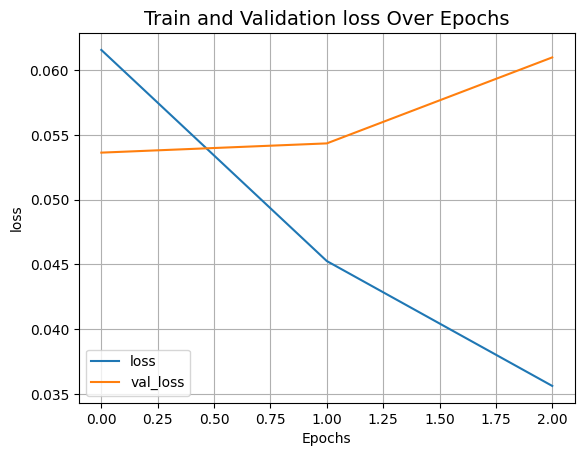

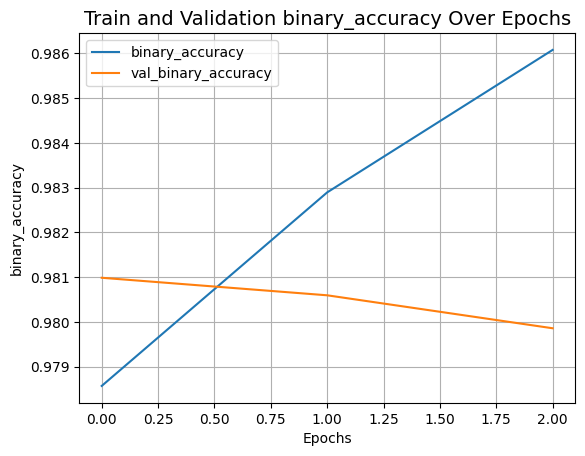

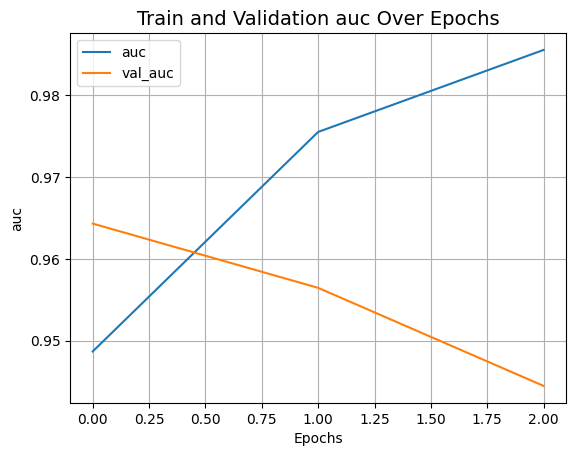

In [ ]:
train_model(model_glove, EarlyStopping(monitor="val_loss", min_delta = 0.01, patience=2, restore_best_weights=True))

In [ ]:
model_glove.evaluate(ds_test)

1000/1000 [==============================] - 6s 6ms/step - loss: 0.0814 - binary_accuracy: 0.9678 - auc: 0.9626


[0.08137789368629456, 0.9677523970603943, 0.9626419544219971]

1000/1000 [==============================] - 5s 5ms/step
ROC AUC Score per Label	 [0.9555217  0.97934675 0.96687034 0.97814804 0.96190252 0.97460425]
Micro ROC AUC Score	 0.973863954610101
Macro ROC AUC Score	 0.969398934790143
Weighted ROC AUC Score	 0.9617887463880962
               precision    recall  f1-score   support

        toxic       0.53      0.83      0.64      6090
 severe_toxic       0.35      0.18      0.24       367
      obscene       0.64      0.69      0.67      3691
       threat       0.44      0.30      0.36       211
       insult       0.55      0.68      0.61      3427
identity_hate       0.69      0.28      0.40       712

    micro avg       0.56      0.71      0.62     14498
    macro avg       0.53      0.49      0.49     14498
 weighted avg       0.56      0.71      0.61     14498
  samples avg       0.07      0.07      0.07     14498



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


toxic - Acc: 0.9123 - Recall: 0.8266 - Precision: 0.5251 - F1 score: 0.6423


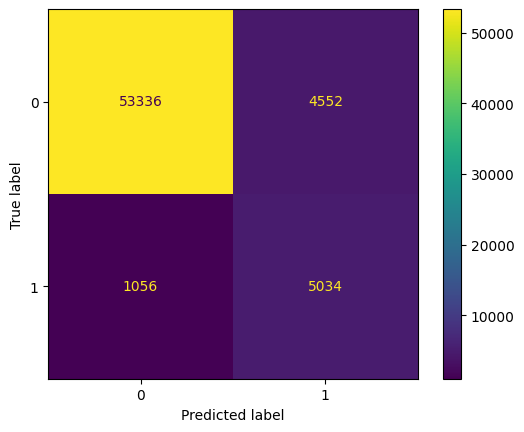

severe_toxic - Acc: 0.9934 - Recall: 0.1798 - Precision: 0.3511 - F1 score: 0.2378


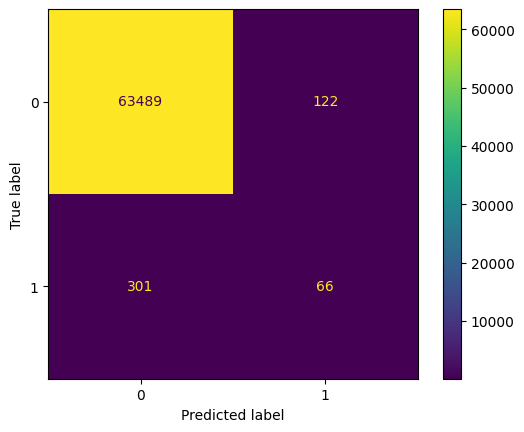

obscene - Acc: 0.9602 - Recall: 0.6922 - Precision: 0.6446 - F1 score: 0.6675


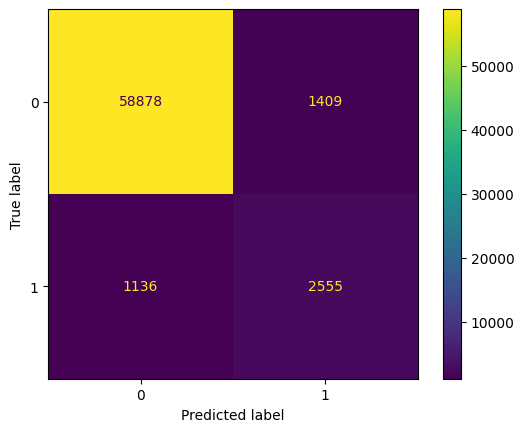

threat - Acc: 0.9965 - Recall: 0.3033 - Precision: 0.4444 - F1 score: 0.3606


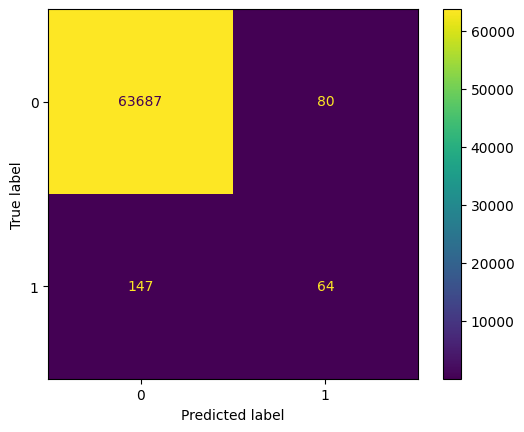

insult - Acc: 0.9535 - Recall: 0.6793 - Precision: 0.5540 - F1 score: 0.6103


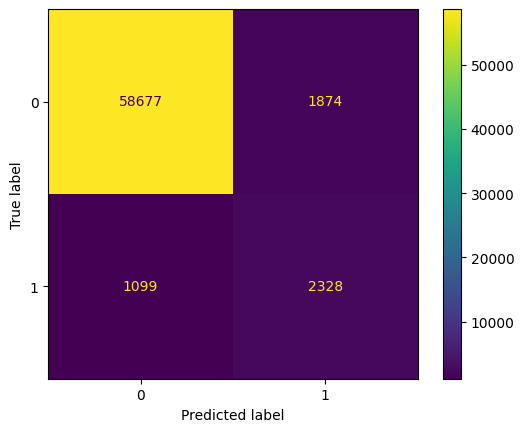

identity_hate - Acc: 0.9906 - Recall: 0.2781 - Precision: 0.6899 - F1 score: 0.3964


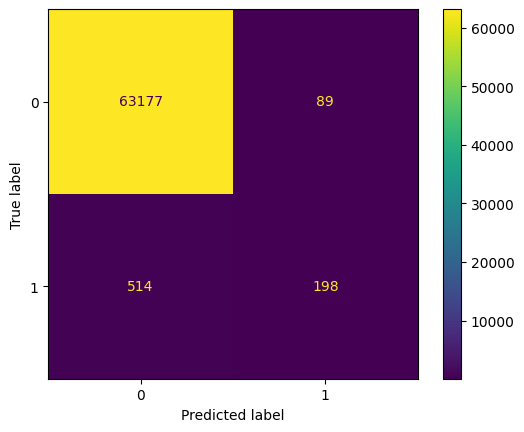

In [ ]:
mg_preds = model_metrics(model_glove)

In [ ]:
all_zero_predictions = model_comments(3, mg_preds)
print(f'Percentage of all-zero predictions {all_zero_predictions:.4f} %')

-----
fucking cunt head tell welcome go fucking die twice cunt deserve gassing:
	[1 0 1 1 1 0]	[0 0 0 0 0 0]
-----
shut asswipe dont care ill decapitate mother shit herhis neck go back jewland fuck httpenwikipediaorgwikithe real stephen hawkinghttpenwikipediaorgwikithe real stephen hawkinghttpenwikipediaorgwikithe real stephen hawkinghttpenwikipediaorgwikithe real stephen hawkinghttpenwikipediaorgwikithe real stephen hawkinghttpenwikipediaorgwikithe real stephen hawkinghttpenwikipediaorgwikithe real stephen hawkinghttpenwikipediaorgwikithe real stephen hawkinghttpenwikipediaorgwikithe real stephen hawkinghttpenwikipediaorgwikithe real stephen hawkinghttpenwikipediaorgwikithe real stephen hawkinghttpenwikipediaorgwikithe real stephen hawkinghttpenwikipediaorgwikithe real stephen hawkinghttpenwikipediaorgwikithe real stephen hawkinghttpenwikipediaorgwikithe real stephen hawkinghttpenwikipediaorgwikithe real stephen hawkinghttpenwikipediaorgwikithe real stephen hawkinghttpenwikipediaorgwi

In [ ]:
all_zero_predictions = model_comments(5, mg_preds)
print(f'Percentage of all-zero predictions {all_zero_predictions:.4f} %')

-----
usernawlinwiki gay person gay deleted spunka page gayyyyyyyyyyy:
	[1 0 0 0 1 1]	[0 0 0 0 0 0]
-----
ea bunch homosexual like make good game ruin making money game fp ea bunch homosexual like make good game ruin making money game fp ea bunch homosexual like make good game ruin making money game fp ea bunch homosexual like make good game ruin making money game fp ea bunch homosexual like make good game ruin making money game fp ea bunch homosexual like make good game ruin making money game fp ea bunch homosexual like make good game ruin making money game fp ea bunch homosexual like make good game ruin making money game fp ea bunch homosexual like make good game ruin making money game fp ea bunch homosexual like make good game ruin making money game fp ea bunch homosexual like make good game ruin making money game fp ea bunch homosexual like make good game ruin making money game fp ea bunch homosexual like make good game ruin making money game fp ea bunch homosexual like make good g

### GLOVE (TRAINABLE WEIGHTS)

In [ ]:
embedding_layer_glove.trainable = True
model_glove.compile(
  loss="binary_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=0.0001), metrics=["binary_accuracy", auc_metric]
)

Epoch 1/20
1995/1995 [==============================] - 163s 81ms/step - loss: 0.0385 - binary_accuracy: 0.9851 - auc: 0.9765 - val_loss: 0.0528 - val_binary_accuracy: 0.9815 - val_auc: 0.9591
Epoch 2/20
1995/1995 [==============================] - 59s 30ms/step - loss: 0.0313 - binary_accuracy: 0.9877 - auc: 0.9911 - val_loss: 0.0559 - val_binary_accuracy: 0.9812 - val_auc: 0.9544
Epoch 3/20
1995/1995 [==============================] - 60s 30ms/step - loss: 0.0241 - binary_accuracy: 0.9906 - auc: 0.9941 - val_loss: 0.0617 - val_binary_accuracy: 0.9813 - val_auc: 0.9412


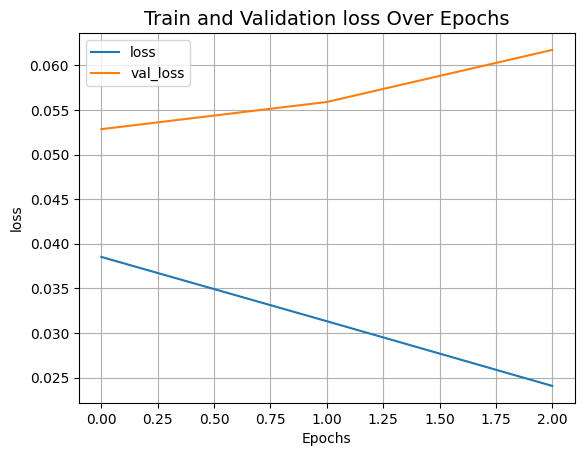

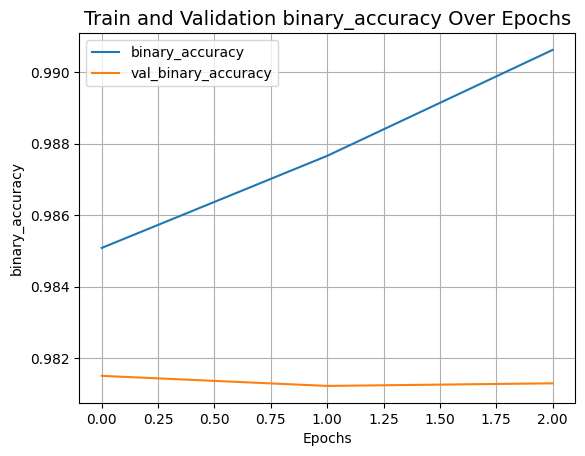

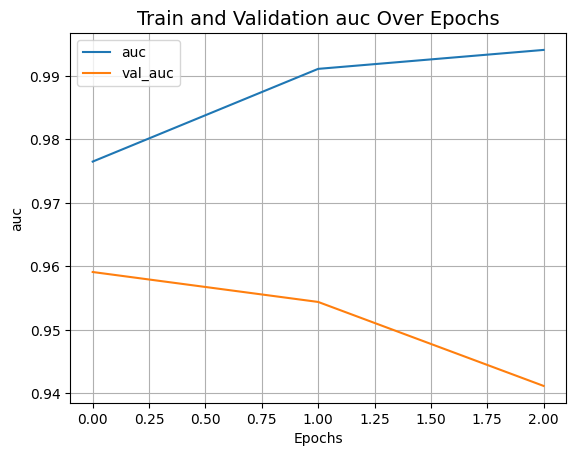

In [ ]:
train_model(model_glove, EarlyStopping(monitor="val_loss", min_delta = 0.005, patience=2, restore_best_weights=True))

In [ ]:
model_glove.evaluate(ds_test)

1000/1000 [==============================] - 6s 6ms/step - loss: 0.0836 - binary_accuracy: 0.9673 - auc: 0.9619


[0.08364742994308472, 0.9673115611076355, 0.9619083404541016]

1000/1000 [==============================] - 5s 5ms/step
ROC AUC Score per Label	 [0.95800291 0.98402796 0.96892808 0.98408639 0.96600338 0.9781818 ]
Micro ROC AUC Score	 0.9765155084317283
Macro ROC AUC Score	 0.9732050862159959
Weighted ROC AUC Score	 0.9647048403561151
               precision    recall  f1-score   support

        toxic       0.52      0.84      0.65      6090
 severe_toxic       0.33      0.50      0.39       367
      obscene       0.62      0.73      0.67      3691
       threat       0.40      0.44      0.42       211
       insult       0.56      0.73      0.63      3427
identity_hate       0.61      0.48      0.54       712

    micro avg       0.55      0.76      0.64     14498
    macro avg       0.51      0.62      0.55     14498
 weighted avg       0.56      0.76      0.64     14498
  samples avg       0.07      0.07      0.07     14498

toxic - Acc: 0.9121 - Recall: 0.8445 - Precision: 0.5238 - F1 score: 0.6466


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


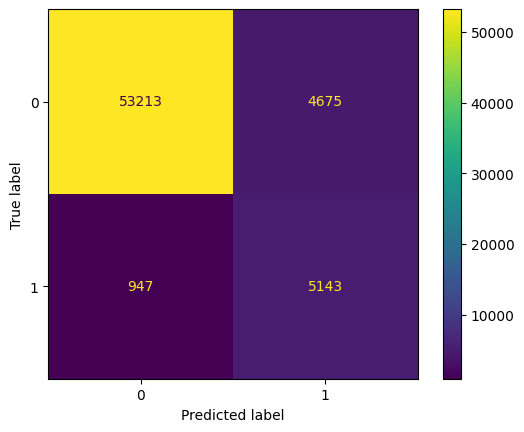

severe_toxic - Acc: 0.9912 - Recall: 0.4959 - Precision: 0.3256 - F1 score: 0.3931


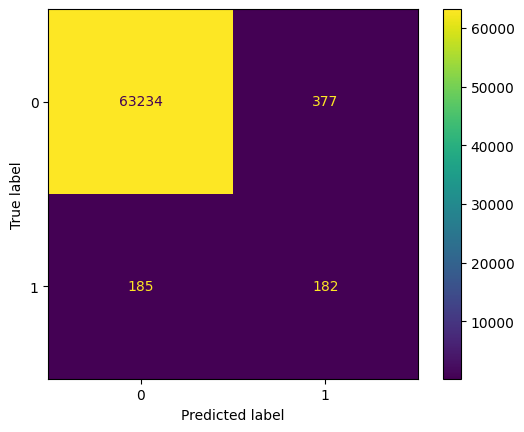

obscene - Acc: 0.9592 - Recall: 0.7337 - Precision: 0.6244 - F1 score: 0.6746


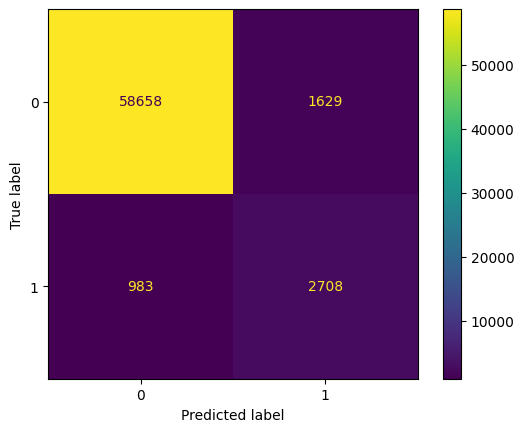

threat - Acc: 0.9960 - Recall: 0.4408 - Precision: 0.4043 - F1 score: 0.4218


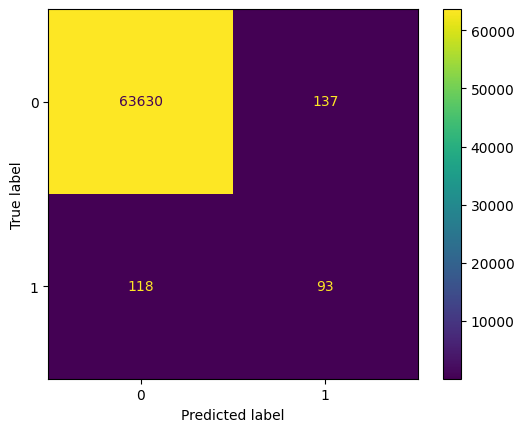

insult - Acc: 0.9545 - Recall: 0.7272 - Precision: 0.5576 - F1 score: 0.6312


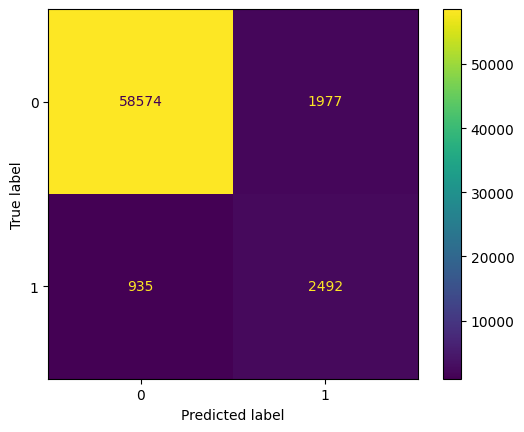

identity_hate - Acc: 0.9909 - Recall: 0.4831 - Precision: 0.6132 - F1 score: 0.5405


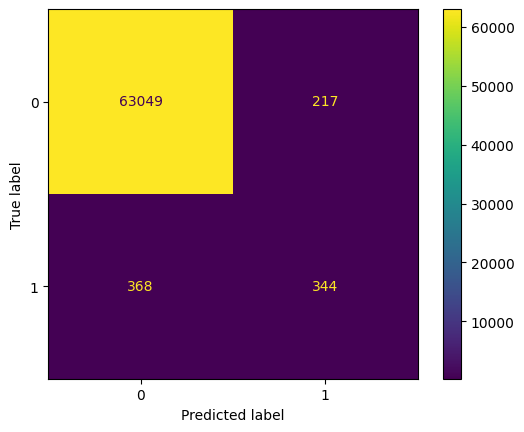

In [ ]:
mgt_preds = model_metrics(model_glove)

In [ ]:
all_zero_predictions = model_comments(3, mgt_preds)
print(f'Percentage of all-zero predictions {all_zero_predictions:.4f} %')

-----
fucking cunt head tell welcome go fucking die twice cunt deserve gassing:
	[1 0 1 1 1 0]	[0 0 0 0 0 0]
-----
shut asswipe dont care ill decapitate mother shit herhis neck go back jewland fuck httpenwikipediaorgwikithe real stephen hawkinghttpenwikipediaorgwikithe real stephen hawkinghttpenwikipediaorgwikithe real stephen hawkinghttpenwikipediaorgwikithe real stephen hawkinghttpenwikipediaorgwikithe real stephen hawkinghttpenwikipediaorgwikithe real stephen hawkinghttpenwikipediaorgwikithe real stephen hawkinghttpenwikipediaorgwikithe real stephen hawkinghttpenwikipediaorgwikithe real stephen hawkinghttpenwikipediaorgwikithe real stephen hawkinghttpenwikipediaorgwikithe real stephen hawkinghttpenwikipediaorgwikithe real stephen hawkinghttpenwikipediaorgwikithe real stephen hawkinghttpenwikipediaorgwikithe real stephen hawkinghttpenwikipediaorgwikithe real stephen hawkinghttpenwikipediaorgwikithe real stephen hawkinghttpenwikipediaorgwikithe real stephen hawkinghttpenwikipediaorgwi

In [ ]:
all_zero_predictions = model_comments(5, mgt_preds)
print(f'Percentage of all-zero predictions {all_zero_predictions:.4f} %')

-----
usernawlinwiki gay person gay deleted spunka page gayyyyyyyyyyy:
	[1 0 0 0 1 1]	[0 0 0 0 0 0]
-----
ea bunch homosexual like make good game ruin making money game fp ea bunch homosexual like make good game ruin making money game fp ea bunch homosexual like make good game ruin making money game fp ea bunch homosexual like make good game ruin making money game fp ea bunch homosexual like make good game ruin making money game fp ea bunch homosexual like make good game ruin making money game fp ea bunch homosexual like make good game ruin making money game fp ea bunch homosexual like make good game ruin making money game fp ea bunch homosexual like make good game ruin making money game fp ea bunch homosexual like make good game ruin making money game fp ea bunch homosexual like make good game ruin making money game fp ea bunch homosexual like make good game ruin making money game fp ea bunch homosexual like make good game ruin making money game fp ea bunch homosexual like make good g